# Splice Site Detection Test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from ucimlrepo import fetch_ucirepo

In [2]:
ds = fetch_ucirepo(id=69)
X, y = ds.data.features, ds.data.targets

# Wrap X in DataFrame
if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X)

# If X is a single string column, split into Base1…Base60
if X.shape[1] == 1 and X.dtypes.iloc[0] == object:
    seq_series = X.iloc[:, 0].astype(str)
    seq_cols = [f"Base{i}" for i in range(1, 61)]
    df_bases = seq_series.apply(lambda s: pd.Series(list(s), index=seq_cols))
    X = df_bases

# Combine with labels
df = pd.concat([y, X], axis=1)

# molecular_biology_splice_junction_gene_sequences = fetch_ucirepo(id=69) 
# X = molecular_biology_splice_junction_gene_sequences.data.features 
# y = molecular_biology_splice_junction_gene_sequences.data.targets

In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["class"], random_state=42)
train_df, val_df   = train_test_split(train_df, test_size=0.1, stratify=train_df["class"], random_state=42)

### Constants and Mappings

Variable Information:

1.   One of {n ei ie}, indicating the class.
2.   The instance name.
3. -62.   The remaining 60 fields are the sequence, starting at position -30 and ending at position +30. Each of these fields is almost always filled by one of {a, g, t, c}. Other characters indicate ambiguity among the standard characters according to the following table:
			
character: meaning
+ D:  A or G or T
+ N:  A or G or C or T
+ S:  C or G
+ R:  A or G



In [4]:
BASE2IDX = {"A":0, "C":1, "G":2, "T":3, "D":4, "N":5, "S":6, "R":7}
LABEL_MAP = {"EI":0, "IE":1, "N":2}
IDX2LABEL = {v: k for k, v in LABEL_MAP.items()}
NUM_BASES = len(BASE2IDX)
NUM_CLASSES = len(LABEL_MAP)

In [5]:
# label_map = {"EI": "donor", "IE": "acceptor", "N": "none"}
# y["class"] = y["class"].map(label_map)

### Splice Dataset and Dataloaders

In [6]:
class SpliceDataset(Dataset):
    def __init__(self, df):
        self.seq_cols = [col for col in df.columns if col.startswith("Base")]
        self.X = df[self.seq_cols].values
        self.y = df["class"].map(LABEL_MAP).values

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        seq = self.X[idx]
        idxs = [BASE2IDX.get(b, BASE2IDX["N"]) for b in seq]
        return torch.LongTensor(idxs), torch.tensor(self.y[idx], dtype=torch.long)

In [7]:
# Set the batch size here
BATCH_SIZE = 64

In [8]:
train_loader = DataLoader(SpliceDataset(train_df), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(SpliceDataset(val_df),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(SpliceDataset(test_df),  batch_size=BATCH_SIZE)

### Transformer with Topographic Self-Attention

In [9]:
class TopographicSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, seq_len, sigma=5.0):
        super().__init__()
        self.head_dim = d_model // n_heads
        self.n_heads  = n_heads
        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.out = nn.Linear(d_model, d_model)
        idxs = torch.arange(seq_len)
        dist2 = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).float() ** 2
        bias = -dist2 / (2 * sigma * sigma)
        self.register_buffer("bias", bias)

    def forward(self, x):
        B, L, D = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.chunk(3, dim=-1)
        q = q.view(B, L, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, L, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, L, self.n_heads, self.head_dim).transpose(1, 2)
        scores = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        scores = scores + self.bias.unsqueeze(0).unsqueeze(0)
        attn = torch.softmax(scores, dim=-1)
        out = attn @ v
        out = out.transpose(1, 2).contiguous().view(B, L, D)
        return self.out(out)

In [24]:
class SpliceTransformer(nn.Module):
    def __init__(self, seq_len, num_bases, d_model=16, n_heads=2, num_classes=3, sigma=5.0):
        super().__init__()
        self.embed = nn.Embedding(num_bases, d_model)
        self.attn  = TopographicSelfAttention(d_model, n_heads, seq_len, sigma)
        self.pool  = nn.AdaptiveAvgPool1d(1)
        self.fc    = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embed(x)
        x = self.attn(x)
        x = x.transpose(1, 2)
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

In [25]:
SEQ_LEN = len(train_df.columns) - 1  # subtract 'class' column
model = SpliceTransformer(SEQ_LEN, NUM_BASES, d_model=64, n_heads=4, num_classes=NUM_CLASSES, sigma=5.0).to(device)

### Training and Validation

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [27]:
def evaluate(loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            p = logits.argmax(dim=1)
            preds.extend(p.cpu().numpy())
            labels.extend(yb.cpu().numpy())
    return accuracy_score(labels, preds)

In [28]:
NUM_EPOCHS = 200

In [15]:
# for epoch in range(NUM_EPOCHS):
#     model.train()
#     total_loss = 0
#     for Xb, yb in train_loader:
#         Xb, yb = Xb.to(device), yb.to(device)
#         optimizer.zero_grad()
#         loss = criterion(model(Xb), yb)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item() * Xb.size(0)
#     train_acc = evaluate(train_loader)
#     val_acc = evaluate(val_loader)
#     print(f"Epoch {epoch} | Loss: {total_loss/len(train_df):.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


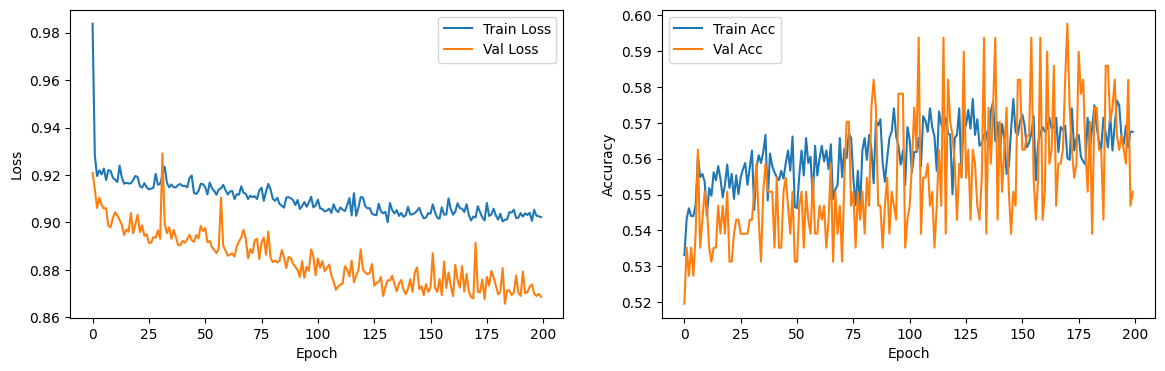

Epoch 199 | Loss: 0.9022 | Val Loss: 0.8686 | Train Acc: 0.5675 | Val Acc: 0.5508


In [ ]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    avg_loss = total_loss / len(train_df)
    train_acc = evaluate(train_loader)
    val_acc = evaluate(val_loader)
    train_losses.append(avg_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Calculate validation loss
    model.eval()
    val_total_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            val_loss = criterion(logits, yb)
            val_total_loss += val_loss.item() * Xb.size(0)
    avg_val_loss = val_total_loss / len(val_df)
    val_losses.append(avg_val_loss)

    clear_output(wait=True)
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    print(f"Epoch {epoch} | Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
